In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

from sigvisa import Sigvisa
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.signals.io import fetch_waveform
from sigvisa.source.event import Event

In [2]:
def setup_graph(sta="PD31"):
    stime = 1239041000 
    etime = 1239041400
    
    
    s = Sigvisa()
    cursor = s.dbconn.cursor()
    wave = fetch_waveform(sta, chan="auto", stime=stime, etime=etime, cursor=cursor)
    wave = wave.filter("freq_0.8_4.5;env;hz_2")
    
    sg = SigvisaGraph(template_model_type="param", template_shape="lin_polyexp",
                      wiggle_model_type="dummy", wiggle_family="iid", 
                      dummy_fallback=True, runids = (3,),
                      phases=["P", "S", "PcP", "ScP", "pP", "Pg", "Lg"], base_srate=2.0,
                      assume_envelopes=True, smoothing=None,
                      hack_param_constraint=True,
                      uatemplate_rate=1e-4)
    sg.add_wave(wave)
    
    vals2 = dict([('mult_wiggle_std', 0.46665908122829375), ('coda_decay', -3.8817786855627583), ('peak_offset', 1.8717964476973965), ('coda_height', 4.6420525405366337), ('arrival_time', 1239041071.3935068), ('peak_decay', -3.3833567577066019)])
    vals30 = dict([('mult_wiggle_std', 0.58921556906392525), ('coda_decay', -2.0648019615477597), ('peak_offset', 1.2059866915167161), ('coda_height', 4.9700447940413781), ('arrival_time', 1239041119.0734844), ('peak_decay', -1.8286789034181647)])
    wn = sg.station_waves.values()[0][0]
    sg.create_unassociated_template(wn, vals2['arrival_time'], tmid=2, initial_vals=vals2)
    sg.create_unassociated_template(wn, vals2['arrival_time'], tmid=30, initial_vals=vals30)
    return sg


In [3]:
sg = setup_graph()
ev = Event(lon=-105.427, lat=43.731, depth=0.0, time=1239041017.07, mb=4.0)


n_uatemplate: -18.5
n_event: -0.6
ev priors: ev 0.0
ev observations: ev 0.0
tt_residual: ev 0.0
ev global cost (n + priors + tt): -0.6
coda_decay: ev 0.0 ua -3.1 total -3.1
peak_decay: ev 0.0 ua -2.5 total -2.5
peak_offset: ev 0.0 ua -3.4 total -3.4
coda_height: ev 0.0 ua -6.1 total -6.1
mult_std_wiggle: ev 0.0 ua -0.3 total -0.3
coef jointgp: 0.0
total param: ev 0.0 ua -15.4 total -15.4
priors+params: ev -0.6 ua -33.9 total -34.4
station noise (observed signals): -1418.9
noise model prior lp: 7.2
overall: -1446.1
official: -1446.1
plotting uatemplate -2 as color (0.0, 0.72352941176470587, 1.0, 1.0)
plotting uatemplate -30 as color (0.0, 0.62941176470588234, 1.0, 1.0)
reading station detections... 


/home/dmoore/python/sigvisa/models/signal_model.py:587: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


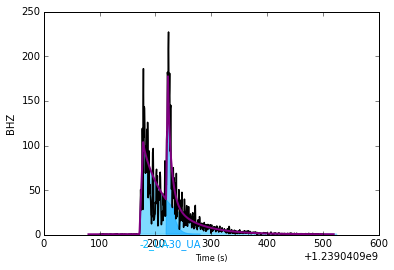

In [4]:
sg.current_log_p_breakdown()
wn = sg.station_waves.values()[0][0]
wn.plot(ax=plt.gca())

In [5]:
def dummy_proposal(sg, fix_result=None):
    ev = Event(lon=-105.427, lat=43.731, depth=0.0, time=1239041017.07, mb=4.0)
    
    if fix_result is not None:
        return 0.0
    
    return ev, 0.0, ()

In [6]:
from sigvisa.infer.event_birthdeath import ev_birth_executor

sg = setup_graph()
ev = Event(lon=-105.427, lat=43.731, depth=0.0, time=1239041017.07, mb=4.0)
wn = sg.station_waves.values()[0][0]

lp_old = sg.current_log_p()
r = ev_birth_executor(sg, dummy_proposal)
#lp_new = sg.current_log_p()

odds for Lg 30 are 433.065755214
odds for P 2 are 383.456880138
odds for Pg 2 are 1144.18094202
odds for S 30 are 4.39010556746
using assoc [('Lg', 30), ('P', None), ('Pg', 2), ('S', None)] with lp -0.302057551066
param mult_wiggle_std val 0.80949421781 lp 0.973345932089
param coda_decay val -3.85827232737 lp -1.41673465217
param peak_offset val -0.324264526593 lp -1.61266799733
param peak_decay val -2.53650346626 lp -1.49693617575
param mult_wiggle_std val 0.70565059077 lp 0.0179068707843
param coda_decay val -1.08259321265 lp -1.28001998718
param peak_offset val -0.168041790467 lp -1.52818264063
param peak_decay val -0.874422659329 lp -1.40127662631
P peak_offset 1.39962945055 -1.69848609466 -0.843474329733 0.0394693858552 -1.43720604297
P tt_residual -2.66000959429 -1.91130130296 0.534188483327 -3.55030661781 4.95994108331
P amp_transfer -1.65686950903 -1.1509298098 -0.718964205857 -0.69241821662 -1.81530501534
P peak_decay -3.25747418904 -1.5834019218 -1.22255808384 -4.24769731103 

In [7]:
lp_new, lp_old, log_qforward, log_qbackward, rebirth, redeath, proposal_extra = r

In [8]:
print "birth move acceptance", (lp_new + log_qbackward) - (lp_old+log_qforward), "from", lp_old, lp_new, log_qbackward, log_qforward
_, eid, debug_info = proposal_extra


birth move acceptance -6.38505507468 from -1446.11046805 -1465.72639419 -0.00987828502673 -13.2407493441


In [9]:
from sigvisa.infer.event_birthdeath import prettyprint_debug
debug_info["PD31"]["wn_old"] = wn.log_p()
rebirth()
debug_info["PD31"]["wn_new"] = wn.log_p()
s = prettyprint_debug(debug_info)
print s

proposed ev evid None, loc 105.43 W 43.73 N, depth 0.0km, time 1239041017.1, mb 4.0, natural source
proposal logq 0.00, lps source -0.00, loc -1.97, time 0.00, mb -3.77, nevents -6.67, total -12.41, delta -12.41
sta PD31 wn_old -1418.88 wn_new -1419.70 wn_delta -0.82 assoc -0.30 overall 6.03
 phase Lg: associating tmid 30, score 6.07
   amp_transfer 6.23 ualp -3.13 evlp -1.93 delta 1.19
   coda_decay -2.06 ualp -1.37 evlp -2.95 delta -1.58
   mult_wiggle_std 0.59 ualp 0.15 evlp 0.09 delta -0.07
   peak_decay -1.83 ualp -1.14 evlp -1.30 delta -0.15
   peak_offset 1.21 ualp -1.35 evlp -1.24 delta 0.11
   tt_residual 2.01 ualp -9.21 evlp -2.64 delta 6.57
 phase P: birthing new template, score -5.33
   amp_transfer -1.66 logq -1.15 logp -5.56 delta -4.41
   coda_decay -3.39 logq -1.43 logp -1.42 delta 0.01
   mult_wiggle_std 0.87 logq 1.20 logp 1.17 delta -0.03
   peak_decay -3.26 logq -1.58 logp -1.58 delta 0.00
   peak_offset 1.40 logq -1.70 logp -1.99 delta -0.29
   tt_residual -2.66 lo

In [11]:
sg.current_log_p_breakdown()

n_uatemplate: -18.5
n_event: -0.6
ev priors: ev 0.0
ev observations: ev 0.0
tt_residual: ev 0.0
ev global cost (n + priors + tt): -0.6
coda_decay: ev 0.0 ua -3.1 total -3.1
peak_decay: ev 0.0 ua -2.5 total -2.5
peak_offset: ev 0.0 ua -3.4 total -3.4
coda_height: ev 0.0 ua -6.1 total -6.1
mult_std_wiggle: ev 0.0 ua -0.3 total -0.3
coef jointgp: 0.0
total param: ev 0.0 ua -15.4 total -15.4
priors+params: ev -0.6 ua -33.9 total -34.4
station noise (observed signals): -1418.9
noise model prior lp: 7.2
overall: -1446.1
official: -1446.1


In [11]:
sg.current_log_p_breakdown()

n_uatemplate: -9.3
n_event: -7.2
ev priors: ev -5.7
ev observations: ev 0.0
tt_residual: ev -13.6
ev global cost (n + priors + tt): -26.5
coda_decay: ev -6.8 ua -1.4 total -8.1
peak_decay: ev -7.4 ua -1.1 total -8.5
peak_offset: ev -6.1 ua -1.4 total -7.5
coda_height: ev -9.1 ua -3.1 total -12.2
mult_std_wiggle: ev 3.5 ua 0.2 total 3.7
coef jointgp: 0.0
total param: ev -25.8 ua -6.8 total -32.7
priors+params: ev -52.4 ua -16.1 total -68.5
station noise (observed signals): -1414.9
noise model prior lp: 7.2
overall: -1476.2
official: -1476.2


In [14]:
print debug_info["PD31"]["Lg"].keys()

['tt_residual', 'coda_decay', 'amp_transfer', 'peak_decay', 'peak_offset']


In [21]:
#sg.station_waves.values()[0][0].log_p()
print 

Signal node w/ model wave wave pts 880 @ 2 Hz. time: Mon, 06 Apr 2009 18:03:00 (1239040980.0). 
sta: PD31, chan BHZ. filter_str: ;freq_0.8_4.5;env;hz_2, fraction_valid: 0.909090909091, npts: 880, srate: 2.0, valid_len: 400.0


In [20]:
print wn

Signal node w/ model wave wave pts 880 @ 2 Hz. time: Mon, 06 Apr 2009 18:03:00 (1239040980.0). 
sta: PD31, chan BHZ. filter_str: ;freq_0.8_4.5;env;hz_2, fraction_valid: 0.909090909091, npts: 880, srate: 2.0, valid_len: 400.0


In [22]:
print id(wn)

139636794082832


In [23]:
print id(s)

139636769217232


In [22]:
debug_info.keys()

['Lg', 'P', 'S', 'assoc', 'Pg', 'ev']

array([-1465.29721991])